In [1]:
import torch.nn.functional as F
import torch
import pandas as pd
import os
import numpy as np

In [2]:
num_classes = 2
input_chunk_length = 120

In [3]:
def dscovr_df(filename):
    df = pd.read_csv(os.path.join(os.path.curdir, "data", filename))
    # df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])
    df.index = df["0"]
    return df.drop(columns="0")
# print(dscovr_df("data_2016.csv")["k_index_target"].unique().size)

In [4]:
def anomaly_indices(anomalies_list, df):
    df['row_number'] = df.reset_index().index
    indices = df.loc[anomalies_list]["row_number"].to_list()
    df.drop(columns='row_number', inplace=True)
    return indices

def anomalies_df(filename):
    return pd.read_csv(os.path.join(os.path.curdir, "data", filename), header=None)

In [5]:
fts = [i for i in range(1, 54)] + ["k_index_current"]

In [6]:
def anomalous_dscovr_dataset(anomalies_list, df_full, lookback, num_classes):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    anomaly_entries = df_full.loc[df_full.index.isin(anomalies_list)]
    anomaly_entries["index_tab"] = anomaly_indices(anomalies_list, df_full)
    anomaly_entries["is_storm"] = ~anomaly_entries["storm_id"].isna()

    for ind in anomaly_entries.index:
        i = anomaly_entries["index_tab"].loc[ind]
        feature = df_full.iloc[i - lookback:i].loc[:, fts]
        target = anomaly_entries.loc[ind, "is_storm"]


        target = F.one_hot(torch.tensor(target).to(torch.int64), num_classes).tolist()
        X.append(feature)
        y.append(target)

    N = len(X)
    X, y = np.array(X).reshape(-1), np.array(y).reshape(-1)

    return torch.reshape(torch.from_numpy(X), (N, lookback, -1)), torch.reshape(torch.tensor(y), (-1, num_classes))

In [7]:
from dscovr_dataset import create_dscovr_dataset
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import pandas as pd

df_full = pd.concat([
    dscovr_df(f"data_{year}.csv").interpolate() for year in range(2016, 2024)
])
df_full.rename(columns={str(i): int(i) for i in range(54)}, inplace=True)
anomalies = anomalies_df("fin_timesteps.csv")
X, y = anomalous_dscovr_dataset(anomalies[0].to_list(), df_full, input_chunk_length, 2)

X_train, X_test = X[:100], X[100:]
y_train, y_test = y[:100], y[100:]

data_train = data.TensorDataset(X_train, y_train)
data_test = data.TensorDataset(X_test, y_test)

batch_size = 8
train_loader = data.DataLoader(data_train, shuffle=True, batch_size=batch_size)
test_loader = data.DataLoader(data_test, shuffle=True, batch_size=batch_size * 8)

C:\Users\z\AppData\Local\Temp\ipykernel_42044\2431047419.py:2: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(os.path.curdir, "data", filename))
C:\Users\z\AppData\Local\Temp\ipykernel_42044\2909111268.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dscovr_df(f"data_{year}.csv").interpolate() for year in range(2016, 2024)
C:\Users\z\AppData\Local\Temp\ipykernel_42044\2431047419.py:2: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(os.path.curdir, "data", filename))
C:\Users\z\AppData\Local\Temp\ipykernel_42044\2909111268.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating inste

In [8]:
from transformer_classifier import TransformerClassifier
model = TransformerClassifier(
    num_classes=num_classes,
    input_chunk_length = input_chunk_length,
    d_model = 64,
    input_dim=54,
    nhead = 8,
    dim_feedforward = 256,
    num_layers = 4,
    dropout = 0.4,
    activation = "relu",
    classifier_dropout = 0.4,
).to(device="cuda")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [9]:
from tqdm import tqdm
from torchmetrics.functional import precision, recall, accuracy

n_epochs = 25
for epoch in range(n_epochs):
    model.train()
    prec, rec, acc = [], [], []
    run_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device="cuda"), y_batch.to(device="cuda", dtype=torch.float)
        y_pred = model(X_batch)

        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)

        y_pred = y_pred.argmax(dim=1)
        y_batch = y_batch.argmax(dim=1)
        curr_prec = precision(y_pred, y_batch, "multiclass", num_classes=num_classes, average="macro")
        curr_rec = recall(y_pred, y_batch, "multiclass", num_classes=num_classes, average="macro")
        curr_acc = accuracy(y_pred, y_batch, "multiclass", num_classes=num_classes, average="macro")
        prec.append(curr_prec.item()), rec.append(curr_rec.item()), acc.append(curr_acc.item())
        run_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"For index {epoch}: precision: {sum(prec)/len(prec)} recall: {sum(rec)/len(rec)} acc: {sum(acc)/len(acc)}")
    print("--------------------------------")

    model.eval()
    if epoch % 5 == 4:
        prec, rec, acc = [], [], []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device="cuda"), targets.to(device="cuda")
                y_pred = model(inputs)

                y_pred = y_pred.argmax(dim=1)
                targets = targets.argmax(dim=1)
                curr_prec = precision(y_pred, targets, "multiclass", num_classes=num_classes, average="macro")
                curr_rec = recall(y_pred, targets, "multiclass", num_classes=num_classes, average="macro")
                curr_acc = accuracy(y_pred, targets, "multiclass", num_classes=num_classes, average="macro")
                prec.append(curr_prec.item()), rec.append(curr_rec.item()), acc.append(curr_acc.item())

        # Print accuracy
        print(f"For test: precision: {sum(prec)/len(prec)} recall: {sum(rec)/len(rec)} acc: {sum(acc)/len(acc)}")
        print("--------------------------------")

For index 0: precision: 0.5076923095262967 recall: 0.4130952415558008 acc: 0.4130952415558008
--------------------------------
For index 1: precision: 0.4938186865586501 recall: 0.516895605967595 acc: 0.516895605967595
--------------------------------
For index 2: precision: 0.5693681331781241 recall: 0.6172161193994375 acc: 0.6172161193994375
--------------------------------
For index 3: precision: 0.6105769230769231 recall: 0.6923076923076923 acc: 0.6923076923076923
--------------------------------
For index 4: precision: 0.5265567784125988 recall: 0.5842490861049066 acc: 0.5842490861049066
--------------------------------
For test: precision: 0.4424342066049576 recall: 0.5 acc: 0.5
--------------------------------
For index 5: precision: 0.5288461538461539 recall: 0.6153846153846154 acc: 0.6153846153846154
--------------------------------
For index 6: precision: 0.5810439586639404 recall: 0.6346153846153846 acc: 0.6346153846153846
--------------------------------
For index 7: precis

In [17]:
!pip install seaborn

<Axes: >

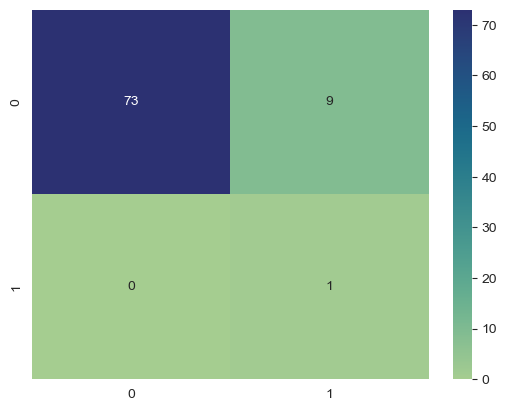

In [19]:
from torchmetrics import ConfusionMatrix
import torch
import seaborn as sns

preds, truths = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device="cuda"), targets.to(device="cuda")
        y_pred = model(inputs)

        y_pred = y_pred.argmax(dim=1)
        targets = targets.argmax(dim=1)

        preds.extend(y_pred.tolist())
        truths.extend(targets.tolist())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(preds, truths)
sns.heatmap(cm, annot=True, fmt="d", cmap="crest")